Artistic Style Transfer with TensorFlow Lite
# https://www.tensorflow.org/lite/examples/style_transfer/overview?authuser=3

In [20]:
import tensorflow as tf
print(tf.__version__)

import IPython.display as display

import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

import PIL

import io
from google.colab import files

import os
import shutil

from os import listdir
from os.path import isfile, join


2.9.2


# Data Access Methods

In [ ]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

284398/284398 [==============================] - 0s 0us/step


In [ ]:

content_path = files.upload()
print(f"content_path->{content_path}")
# style_path = files.upload()
# print(f"style_path->{style_path}")


Saving Sketch 1-page-001.jpg to Sketch 1-page-001.jpg
content_path->{'Sketch 1-page-001.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x96\x00\x96\x00\x00\xff\xe1\x10\xeaExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x06\x00\x0b\x00\x02\x00\x00\x00&\x00\x00\x08b\x01\x12\x00\x03\x00\x00\x00\x01\x00\x08\x00\x00\x011\x00\x02\x00\x00\x00&\x00\x00\x08\x88\x012\x00\x02\x00\x00\x00\x14\x00\x00\x08\xae\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x08\xc2\xea\x1c\x00\x07\x00\x00\x08\x0c\x00\x00\x00V\x00\x00\x00\x00\x1c\xea\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [ ]:
style_path = "/content/style13.jpg"
# content_path = "/content/PXL_20221223_034307654.jpg"
content_path = "/content/Sketch 1-page-001.jpg"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/TucDataSets/tf-style/styles


style0.jpg   style14.jpg  style19.jpg  style23.jpg  style4.jpg	style9.jpg
style10.jpg  style15.jpg  style1.jpg   style24.jpg  style5.jpg
style11.jpg  style16.jpg  style20.jpg  style25.jpg  style6.jpg
style12.jpg  style17.jpg  style21.jpg  style2.jpg   style7.jpg
style13.jpg  style18.jpg  style22.jpg  style3.jpg   style8.jpg


In [ ]:
!ls gdrive/MyDrive/TucDataSets/tf-style/content

 PXL_20221223_034225265.jpg  'Sketch 5, R3-oval.png'
 PXL_20221223_034242926.jpg  'Sketch 5, R3-rect-crop.png'
 PXL_20221223_034307654.jpg  'Sketches 1, R3-oval.png'
'Sketch 1-page-001.jpg'      'Sketches 2, R3-free.png'
'Sketch 4, R3-oval.png'


In [ ]:
style_path = "/content/gdrive/MyDrive/TucDataSets/tf-style/styles/style1.jpg"
style_path

'/content/gdrive/MyDrive/TucDataSets/tf-style/styles/style1.jpg'

In [ ]:
content_path = "/content/gdrive/MyDrive/TucDataSets/tf-style/content/PXL_20221223_034242926.jpg"
content_path

'/content/gdrive/MyDrive/TucDataSets/tf-style/content/PXL_20221223_034242926.jpg'

# Standalone Functions

In [2]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img


In [3]:
# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image


In [4]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


In [5]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck


In [6]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image


# Sample Cells per Image

In [37]:
# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


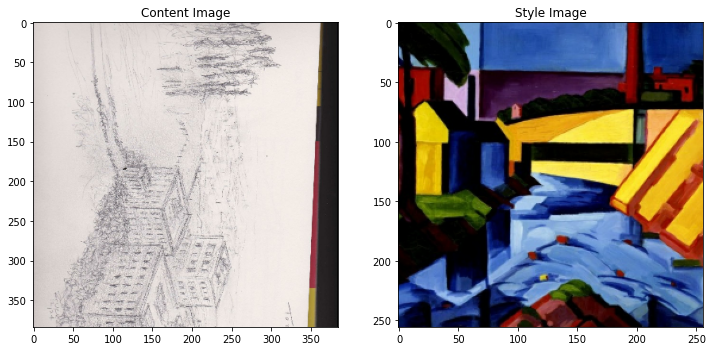

In [38]:
plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

In [39]:
# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)


Style Bottleneck Shape: (1, 1, 1, 100)


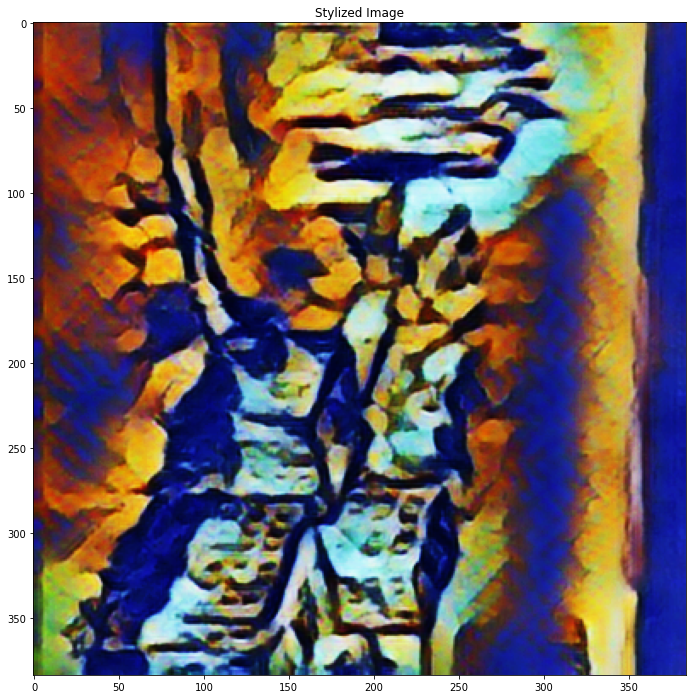

In [40]:
# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

In [41]:
# export_image(stylized_image).save("stylized_image1.png")
# export_image(stylized_image).save("stylized_image2.png")
export_image(stylized_image).save("stylized_image3.png")

In [42]:
!ls
!ls sample_data


gdrive	     stylized_image3.png  stylized_image_dir.zip
sample_data  stylized_image_dir
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [43]:
# stylized_file = "/content/stylized_image1.png"
#stylized_file = "/content/stylized_image2.png"
stylized_file = "/content/stylized_image3.png"
files.download(stylized_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256))

In [45]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
#content_blending_ratio = 0.5
content_blending_ratio = 0.7  # blends more from content
#content_blending_ratio = 0.9  # blends mostly from content
#content_blending_ratio = 0.1 # blends mostly from style

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

KeyboardInterrupt: ignored

In [ ]:
!ls 


In [ ]:
#export_image(stylized_image).save("stylized_image_blended1.png")

export_image(stylized_image_blended).save("stylized_image_blended3.png")
stylized_image_blended = "/content/stylized_image_blended3.png"
files.download(stylized_image_blended)

# Generator Data Prep

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
!pwd

/content


In [9]:
!ls /content
!ls /content/sample_data

gdrive	     stylized_image3.png  stylized_image_dir.zip
sample_data  stylized_image_dir
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [10]:
!ls /content/gdrive/MyDrive/TucDataSets/tf-style/styles

style0.jpg   style14.jpg  style19.jpg  style23.jpg  style4.jpg	style9.jpg
style10.jpg  style15.jpg  style1.jpg   style24.jpg  style5.jpg
style11.jpg  style16.jpg  style20.jpg  style25.jpg  style6.jpg
style12.jpg  style17.jpg  style21.jpg  style2.jpg   style7.jpg
style13.jpg  style18.jpg  style22.jpg  style3.jpg   style8.jpg


In [11]:
!ls gdrive/MyDrive/TucDataSets/tf-style/content

1-harbor-color.jpg    4-hall-sketch.png  7-passage-sketch.png
2-citidel-color.jpg   5-farm-sketch.png  8-galaxy-color.jpg
3-citidel-sketch.jpg  6-gate-sketch.png


# Generator Fun

In [12]:
#import os, shutil
def delete_folder_contents(folder):
  #folder = '/path/to/folder'
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

In [13]:
def export_image(tf_img):
    tf_img = tf_img*255
    tf_img = np.array(tf_img, dtype=np.uint8)
    if np.ndim(tf_img)>3:
        assert tf_img.shape[0] == 1
        img = tf_img[0]
    return PIL.Image.fromarray(img)

In [14]:
def load_image(content_path, style_path):
  # Load the input images.
  content_image = load_img(content_path)
  style_image = load_img(style_path)
  return content_image, style_image


In [15]:
def preprocess(content_image, style_image):
  # Load the input images.
  content_image = load_img(content_path)
  style_image = load_img(style_path)

  # Preprocess the input images.
  preprocessed_content_image = preprocess_image(content_image, 384)
  preprocessed_style_image = preprocess_image(style_image, 256)

  #print('Style Image Shape:', preprocessed_style_image.shape)
  #print('Content Image Shape:', preprocessed_content_image.shape)

  return preprocessed_content_image, preprocessed_style_image

In [16]:
def show_preprocess(preprocessed_content_image, preprocessed_style_image, row = 1):
  plt.subplot(1, 2, 1)
  imshow(preprocessed_content_image, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(preprocessed_style_image, 'Style Image')

In [17]:
def bottleneck(preprocessed_content_image, preprocessed_style_image):
  # Calculate style bottleneck for the preprocessed style image.
  style_bottleneck = run_style_predict(preprocessed_style_image)
  #print('Style Bottleneck Shape:', style_bottleneck.shape)  

  # Stylize the content image using the style bottleneck.
  stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

  # Visualize the output.
  #imshow(stylized_image, 'Stylized Image')

  return stylized_image, style_bottleneck

In [18]:
def blend(content_image, style_bottleneck, preprocessed_content_image):
  # Calculate style bottleneck of the content image.
  style_bottleneck_content = run_style_predict(preprocess_image(content_image, 256))
  
  # Define content blending ratio between [0..1].
  # 0.0: 0% style extracts from content image.
  # 1.0: 100% style extracted from content image.
  #content_blending_ratio = 0.5
  content_blending_ratio = 0.7  # blends more from content

  # Blend the style bottleneck of style image and content image
  style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                            + (1 - content_blending_ratio) * style_bottleneck

  # Stylize the content image using the style bottleneck.
  stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                              preprocessed_content_image)
  return stylized_image_blended


# Run Generator

In [19]:
# download tfhub style & transfer
style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')


In [21]:
# from os import listdir
# from os.path import isfile, join

# content_path = "/content/gdrive/MyDrive/TucDataSets/tf-style/content/PXL_20221223_034242926.jpg"
# print(f"content_path->", content_path)

style_dir = "/content/gdrive/MyDrive/TucDataSets/tf-style/styles/"
print(f"style_dir->", style_dir)

style_list = [f for f in listdir(style_dir) if isfile(join(style_dir, f))]
print(f"style_list->", style_list)

content_dir = "/content/gdrive/MyDrive/TucDataSets/tf-style/content/"
print(f"content_dir->", content_dir)

content_list = [f for f in listdir(content_dir) if isfile(join(content_dir, f))]
print(f"content_list->", content_list)

from pathlib import Path
Path("/content/stylized_image_dir").mkdir(parents=True, exist_ok=True)

style_dir-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/
style_list-> ['style16.jpg', 'style7.jpg', 'style1.jpg', 'style3.jpg', 'style21.jpg', 'style5.jpg', 'style8.jpg', 'style22.jpg', 'style25.jpg', 'style19.jpg', 'style6.jpg', 'style24.jpg', 'style20.jpg', 'style13.jpg', 'style23.jpg', 'style18.jpg', 'style14.jpg', 'style4.jpg', 'style2.jpg', 'style17.jpg', 'style10.jpg', 'style9.jpg', 'style15.jpg', 'style12.jpg', 'style11.jpg', 'style0.jpg']
content_dir-> /content/gdrive/MyDrive/TucDataSets/tf-style/content/
content_list-> ['8-galaxy-color.jpg', '7-passage-sketch.png', '6-gate-sketch.png', '5-farm-sketch.png', '4-hall-sketch.png', '2-citidel-color.jpg', '1-harbor-color.jpg', '3-citidel-sketch.jpg']


In [22]:
output_dir = "/content/stylized_image_dir/"
delete_folder_contents(output_dir)
# content_path = "/content/gdrive/MyDrive/TucDataSets/tf-style/content/PXL_20221223_034242926.jpg"
# print(f"content_path->", content_path)

for content in content_list:
  content_path = content_dir + content
  content_base_name = content.split('.')[0]
  style_count = 0
  # iterate through styles list generating stylized images & blended images
  for style in style_list:

    style_count = style_count + 1
    style_path = style_dir + style
    print(f"style_path->", style_path)
    content_image, style_image = load_image(content_path, style_path)
    preprocessed_content_image, preprocessed_style_image = preprocess(content_image, style_image)

    stylized_image, style_bottleneck = bottleneck(preprocessed_content_image, preprocessed_style_image)

    stylized_name = content_base_name + "_style" + str(style_count) + ".png"
    export_image(stylized_image).save("/content/stylized_image_dir/" + stylized_name)

    stylized_image_blended = blend(content_image, style_bottleneck, preprocessed_content_image)
    blended_name = content_base_name + "_blended_" + "style" + str(style_count) + ".png"
    export_image(stylized_image_blended).save("/content/stylized_image_dir/" + blended_name)
    # if style_count > 1:
    #   break

zip_filename_base = "stylized_image_dir"
target_dir = "/content/stylized_image_dir"
shutil.make_archive(zip_filename_base, 'zip', target_dir)

zip_filename = "stylized_image_dir" + ".zip"
files.download(zip_filename)


style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style16.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style7.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style1.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style3.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style21.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style5.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style8.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style22.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style25.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style19.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style6.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style24.jpg
style_path-> /content/gdrive/MyDrive/TucDataSets/tf-style/styles/style20.jpg
style

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
#!rm /content/*.png
#!rm /content/*.zip
!ls -l /content/
!ls /content/stylized_image_dir/

total 119064
drwx------ 5 root root      4096 Jan 20 16:33 gdrive
drwxr-xr-x 1 root root      4096 Jan 18 14:55 sample_data
-rw-r--r-- 1 root root    257211 Jan 20 18:51 stylized_image3.png
drwxr-xr-x 2 root root     28672 Jan 20 19:00 stylized_image_dir
-rw-r--r-- 1 root root 121623753 Jan 20 19:00 stylized_image_dir.zip
1-harbor-color_blended_style10.png    5-farm-sketch_blended_style10.png
1-harbor-color_blended_style11.png    5-farm-sketch_blended_style11.png
1-harbor-color_blended_style12.png    5-farm-sketch_blended_style12.png
1-harbor-color_blended_style13.png    5-farm-sketch_blended_style13.png
1-harbor-color_blended_style14.png    5-farm-sketch_blended_style14.png
1-harbor-color_blended_style15.png    5-farm-sketch_blended_style15.png
1-harbor-color_blended_style16.png    5-farm-sketch_blended_style16.png
1-harbor-color_blended_style17.png    5-farm-sketch_blended_style17.png
1-harbor-color_blended_style18.png    5-farm-sketch_blended_style18.png
1-harbor-color_blended_style

In [40]:
# import shutil
# zip_filename_base = "stylized_image_dir"
# target_dir = "/content/stylized_image_dir"
# shutil.make_archive(zip_filename_base, 'zip', target_dir)

'/content/stylized_image_dir.zip'

In [43]:
# zip_filename = "stylized_image_dir" + ".zip"
# files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
# !ls /content/stylized_image_dir/
# output_dir = "/content/stylized_image_dir/"
# delete_folder_contents(output_dir)
# !ls /content/stylized_image_dir/

stylized_image_style4.png
